Let's now examine the performance of integration methods for the following stiff, non-linear ODE system, **Van der Pol's oscillator**. This file solves This file solves the following ordinary differential equation (ODE) system:
    
\begin{eqnarray*}
	\frac{\displaystyle {dy_1(t)} }{\displaystyle {dt} } &=& y_2(t)\\
	\frac{\displaystyle {dy_2(t)} }{\displaystyle {dt} } &=& \lambda\left[1 - y^2_1(t)\right]y_2(t) - y_1(t)
\end{eqnarray*}

where $\lambda \ge 0$ and $[y_1(0), y_2(0)]^T = [2, 1]^T$.

Import

In [1]:
import sys
sys.path.append('..//source')

import matplotlib.pylab as plt
import numpy as np
import numpy.linalg as LA

import scipy, time 
from scipy.interpolate import CubicSpline

import analysis, integrator, params, plotter

import points

In [2]:
%matplotlib notebook

Functions

In [3]:
# the stiffness parameter
K_stiff = 20
# https://www.cs.ox.ac.uk/files/1175/lecture06-handout.pdf

# backward euler, implicit tolerance. Also sused in SDC
BE_TOL = 1e-12
SDC_TOL = 1e-18 #1e-12
N_ITER_MAX_NEWTON=50

def f_eval(t, y):
    
    """
    sovling
    dy1/dt = y2
    dy2/dt = k * (1 - y1^2)y2 - y1
    
    :param float t: the time node
    :param numpy.ndarray: y the approximate solution length( m) at time node t
    """

    F = np.zeros( y.shape )
    m = len(y)
    
    # get the component-wise interaction
    F[0] = y[1]
    F[1] = K_stiff * (1 - y[0]**2) * y[1] - y[0]
    
    return F

def get_corrections_norm(D):
    
    """
    :param numpy.ndarray D: dimensions (the number of iterations, the number of nodes, the dimension of the problem)
    """
    
    y = np.vstack( [ np.linalg.norm(x, axis=0) for x in D] )
    
    return y

def get_stuff(p, dt):
        
    if p.t[-1] != 1:
        t = dt * np.hstack( [p.t, 1])
    else:
        t = dt * p.t
    
    S, S_p = dt * p.S, dt * p.S_p
    
    spectral_radius = p.spectral_radius
    node_type = p.node_type
    
    return t, S, S_p, spectral_radius, node_type



Parameters

In [4]:
#
# set up integration parameters
#

# the parameters of the simulation
n_nodes     = 10

# the time step
dt = .25

# the dimension of the problem
m           = 2

# the initial solution
y0 = np.array( (2, 1) )

# create the parameter object
p_lobatto = params.Params(n_nodes=n_nodes, m=m, node_type=points.GAUSS_LOBATTO)

# create paramter for radau
#p_radau  = params.Params(n_nodes=n_nodes, m=m, node_type=points.GAUSS_RADAU)

# create paramter for radau 2a
#p_radau_2a = params.Params(n_nodes=n_nodes, m=m, node_type=points.GAUSS_RADAU_2A)

# legendre nodes
#p_legendre = params.Params(n_nodes=n_nodes, m=m, node_type=points.GAUSS_LEGENDRE)



---
Run one step

---

Backward Euler

In [5]:
nodes, S, S_p, spectral_radius, node_type = get_stuff(p_lobatto, dt)
y_be = integrator.backward_euler(f_eval, nodes, y0, S_p, be_tol=BE_TOL, do_print=True)

t = nodes
#LA.norm( y_be - exact(t), ord=np.inf)

elapsed time: 0.00[s]


SDC

In [6]:
t, S, S_p, spectral_radius, node_type = get_stuff(p_lobatto, dt)

y_be = integrator.backward_euler(f_eval, t, y0, S_p, be_tol=BE_TOL)

y_sdc, Y_sdc, D_sdc, is_converged_sdc = integrator.sdc(f_eval, t, y0, y_be, S, S_p, be_tol=BE_TOL, sdc_tol=SDC_TOL, do_print=True)
print('SDC converged: %s ' % is_converged_sdc)

# the norm of the corrections
d_norm_sdc, log_d_norm_sdc, d_norm_rel_sdc, log_d_norm_rel_sdc = analysis.analyze_corrections(D_sdc, Y_sdc)

elapsed time: 0.09[s]
SDC converged: True 


..//source/analysis.py:140: RuntimeWarning: divide by zero encountered in log10
  log_d_norm      = np.log10(d_norm)
..//source/analysis.py:141: RuntimeWarning: divide by zero encountered in log10
  log_d_norm_rel  = np.log10(d_norm_rel)


JFNK

In [7]:
t, S, S_p, spectral_radius, node_type = get_stuff(p_lobatto, dt)

y_be = integrator.backward_euler(f_eval, t, y0, S_p, be_tol=BE_TOL)

y_jfnk, Y_jfnk, D_jfnk, is_converged_jfnk, is_stiff,ratios = integrator.jfnk(f_eval, t, y0, y_be, S, S_p, spectral_radius, be_tol=BE_TOL, \
                                                                          sdc_tol=SDC_TOL, do_print=True)
print('JFNK converged: %s ' % is_converged_jfnk)

# the norm of the corrections
d_norm_jfnk, log_d_norm_jfnk, d_norm_rel_jfnk, log_d_norm_rel_jfnk = analysis.analyze_corrections(D_jfnk, Y_jfnk)

elapsed time: 0.06[s]
JFNK converged: True 


..//source/integrator.py:721: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c, res, rank, s = np.linalg.lstsq(B, rhs)
..//source/analysis.py:140: RuntimeWarning: divide by zero encountered in log10
  log_d_norm      = np.log10(d_norm)
..//source/analysis.py:141: RuntimeWarning: divide by zero encountered in log10
  log_d_norm_rel  = np.log10(d_norm_rel)


Spectral Solution

In [8]:
t, S, S_p, spectral_radius, node_type = get_stuff(p_lobatto, dt)

y_be = integrator.backward_euler(f_eval, t, y0, S_p, be_tol=BE_TOL)

y_spect = integrator.run_spectral(f_eval, t, y0, S, tol=1e-10, y_approx=y_be, verbose=True)

0:  |F(x)| = 0.00299999; step 1; tol 3.94638e-06
1:  |F(x)| = 8.14323e-08; step 1; tol 6.63128e-10
2:  |F(x)| = 7.61131e-16; step 1; tol 7.86262e-17


Plot the corrections

<IPython.core.display.Javascript object>


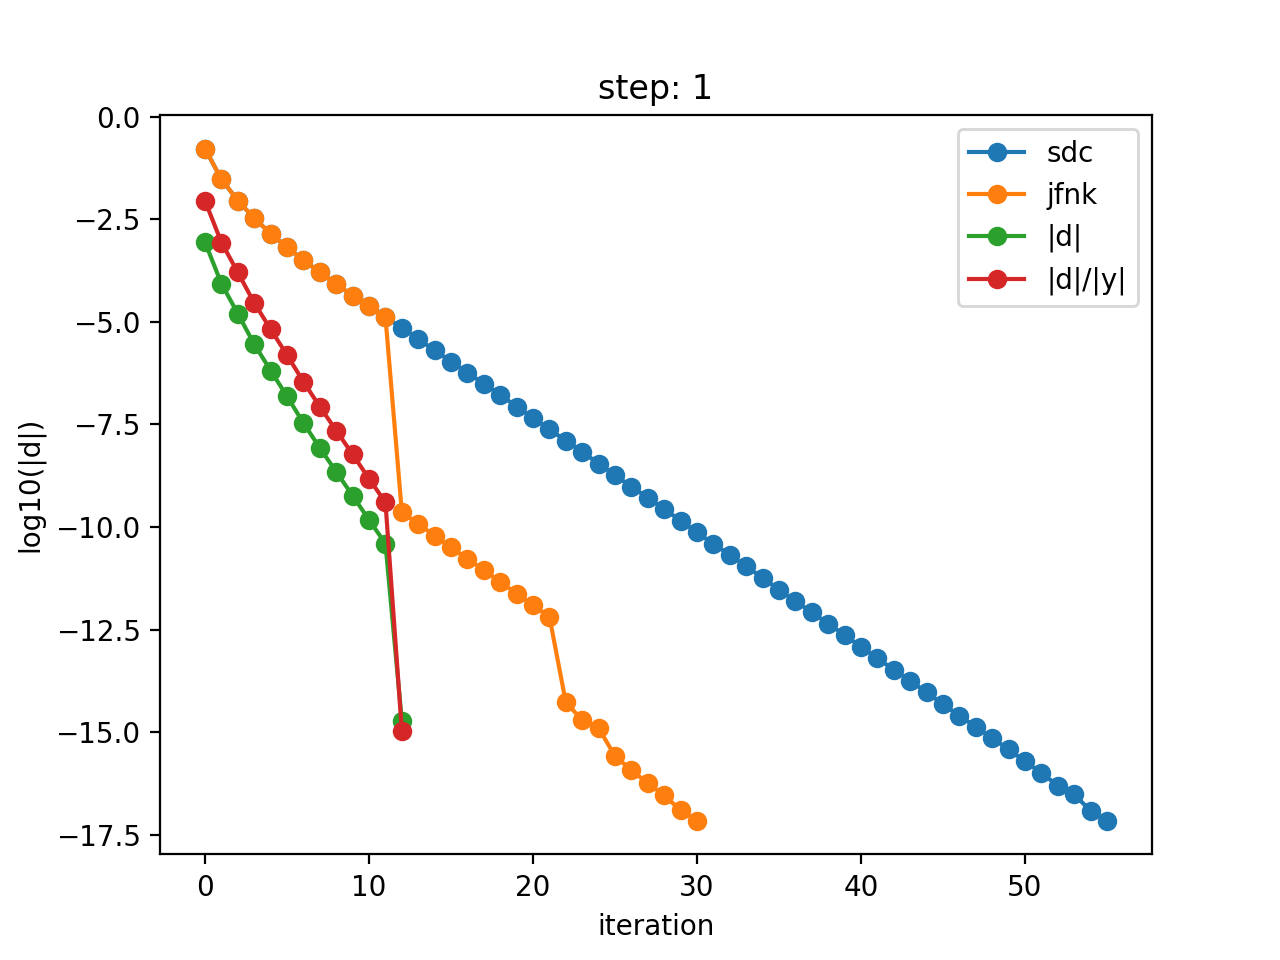

In [9]:
plt.figure()
plt.title('Magnitude of corrections ')

plt.plot( range(log_d_norm_sdc.shape[0]), log_d_norm_sdc.max(axis=1), '-o', label='sdc')
plt.plot( range(log_d_norm_jfnk.shape[0]), log_d_norm_jfnk.max(axis=1), '-o', label='jfnk')

plt.xlabel('SDC iteration')
plt.ylabel('log10 (error)')
plt.legend(loc='best')
plt.show()

---
Run Multiple Steps

---

In [10]:
t_final =1
tol = 1e-5
dt_init = 4e-1

print(t_final, dt_init)

1 0.4


**Adaptive** JFNK

In [11]:
t_adapt, y_adapt, Y_adapt, D_adapt, h_adapt = integrator.jfnk_adaptive(f_eval, t_init=0, t_final=t_final, dt_init=dt_init, p=p_lobatto, y0=y0, \
                                                                       tol=tol, do_print=True)

..//source/integrator.py:721: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c, res, rank, s = np.linalg.lstsq(B, rhs)


elapsed time: 0.35[s]


In [12]:
# the time steps
h_adapt

array([0.3190401 , 0.3190401 , 0.36191979])

**Uniform** JFNK

In [13]:
t_uni, y_uni, Y_uni, D_uni = integrator.jfnk_uniform(f_eval, t_init=0, t_final=t_final, n_steps=12, p=p_lobatto, y0=y0, do_print=True)

..//source/integrator.py:721: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  c, res, rank, s = np.linalg.lstsq(B, rhs)


elapsed time: 0.24[s]


**Reference** solution

In [14]:
# the reference solution
n_steps_ref = 100
p_ref = params.Params(n_nodes=10, m=m, node_type=points.GAUSS_LOBATTO)

t_ref, y_ref, Y_ref, D_ref = integrator.jfnk_uniform(f_eval, t_init=0, t_final=t_final, n_steps=n_steps_ref, p=p_ref, y0=y0, do_print=True)

# spline
y_spline = CubicSpline(t_ref, y_ref)

# errors
f = lambda t, y: ( LA.norm( y_spline(t) - y, ord=np.inf), integrator.relative_norm(y_spline(t) - y, y_spline(t)) )

elapsed time: 1.01[s]


Comparing the absolute and relative erros of the **uniform** solution to the reference solution

In [15]:
f(t_uni, y_uni)

(7.490298863967182e-07, 1.1106575637047464e-06)

Comparing the absolute and relative errors of the **adaptive** solution to the reference solution

In [16]:
f(t_adapt, y_adapt), tol

((0.0016080388293931436, 0.0031861992483273984), 1e-05)

---
Plotting

---

Plot the JFNK corrections for each time step

<IPython.core.display.Javascript object>


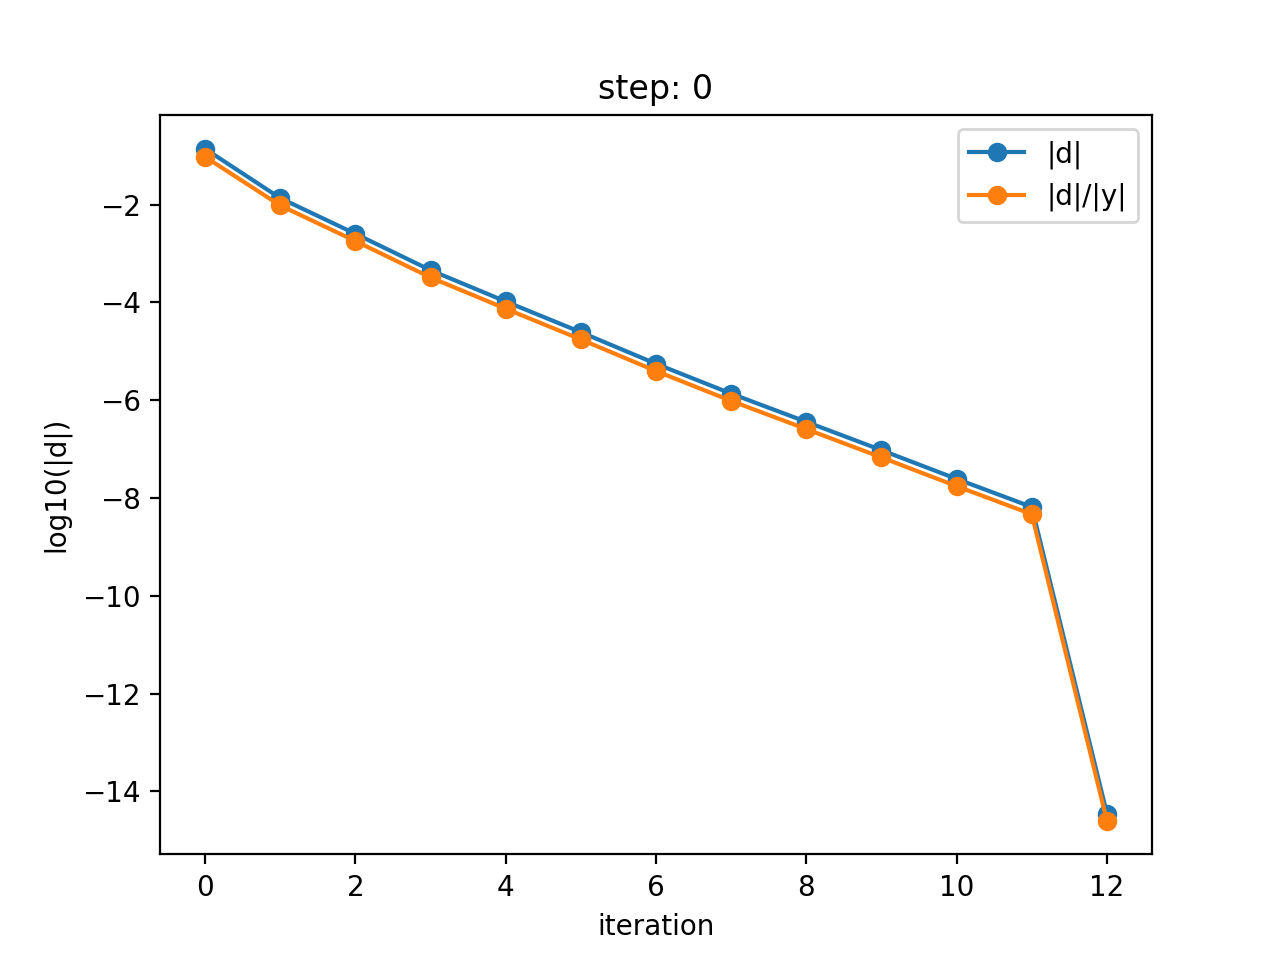

<IPython.core.display.Javascript object>


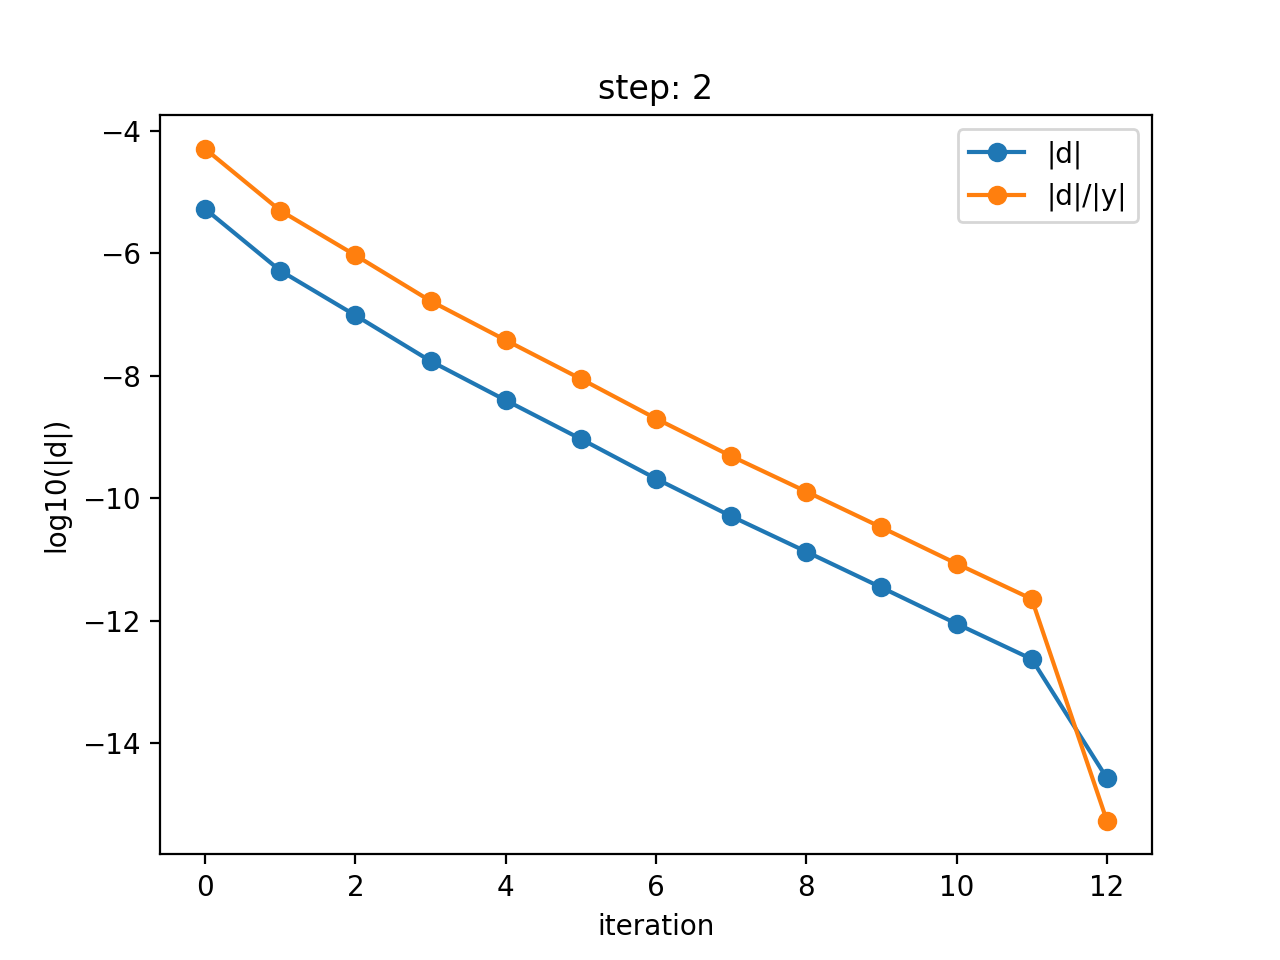

<IPython.core.display.Javascript object>


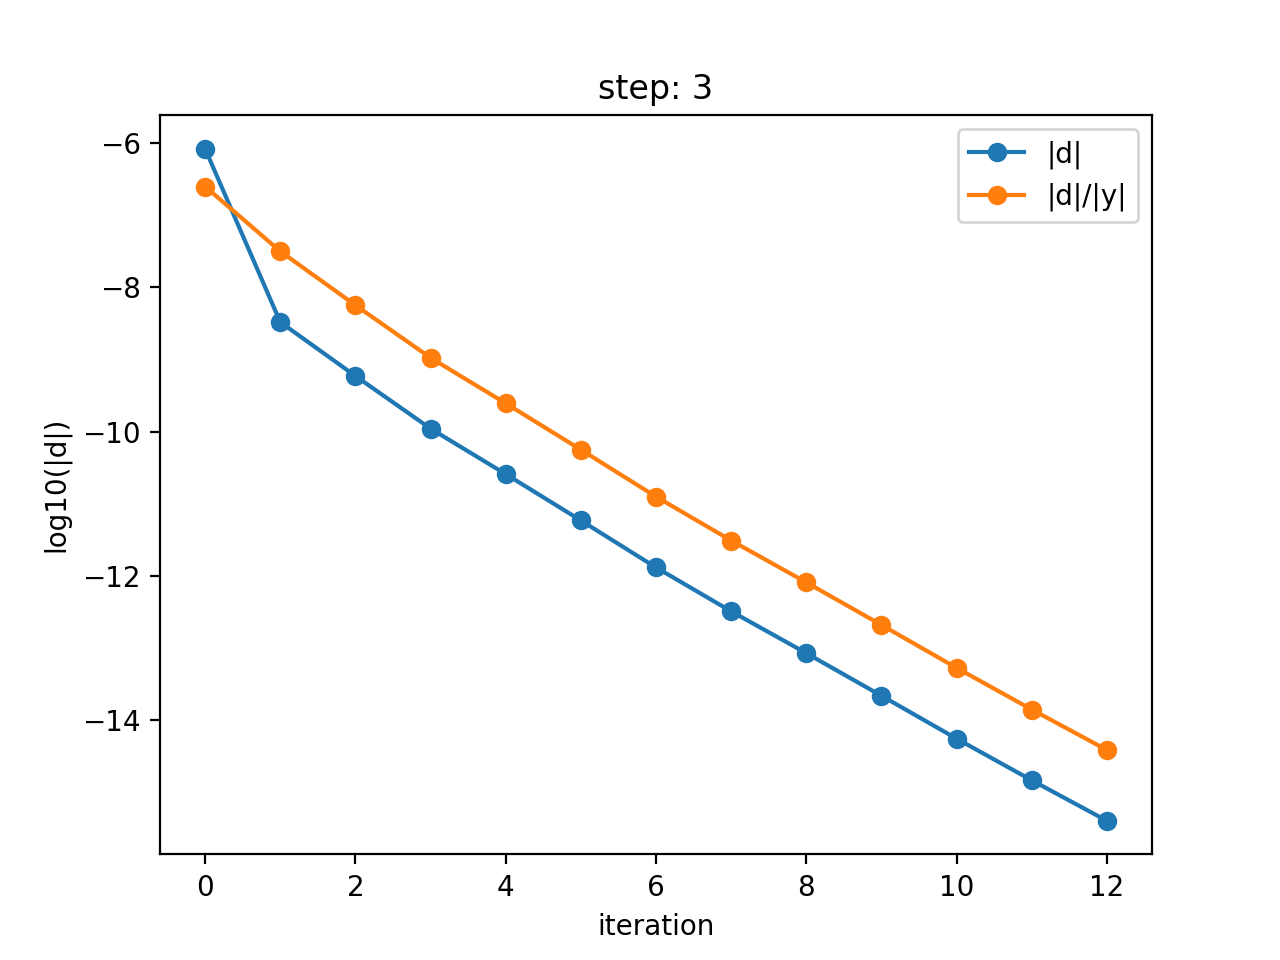

<IPython.core.display.Javascript object>


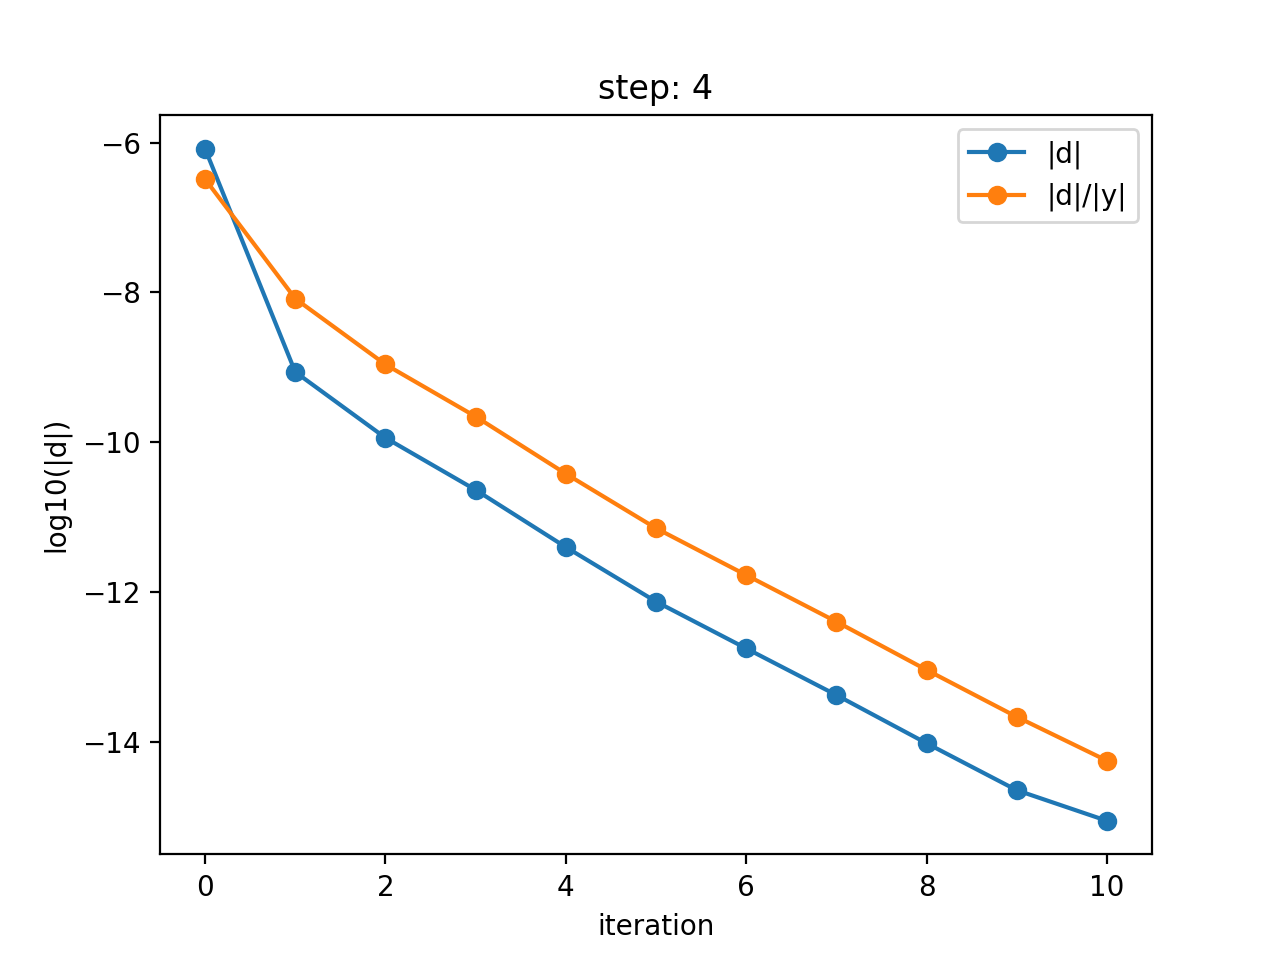

<IPython.core.display.Javascript object>


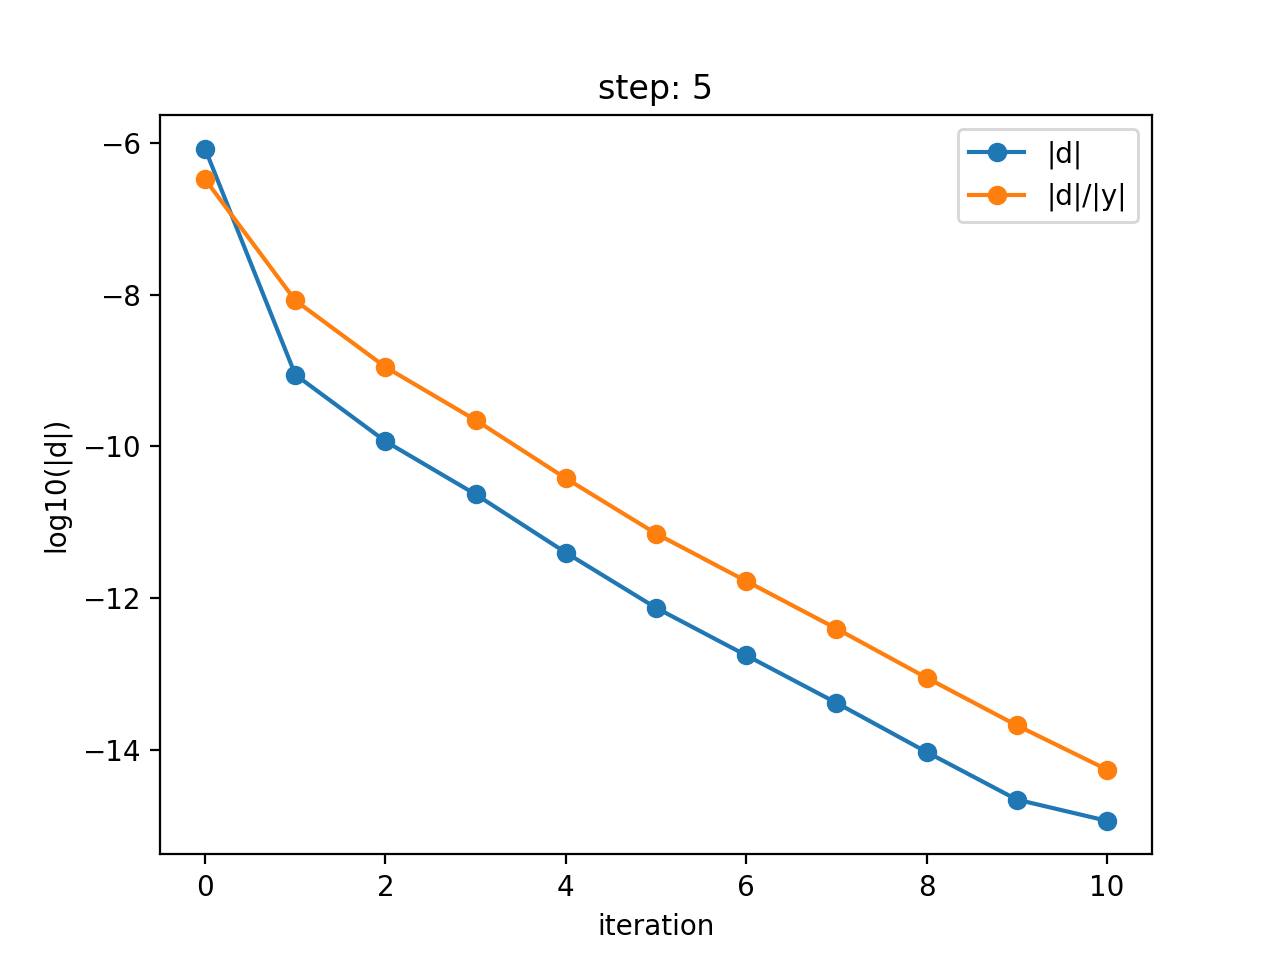

<IPython.core.display.Javascript object>


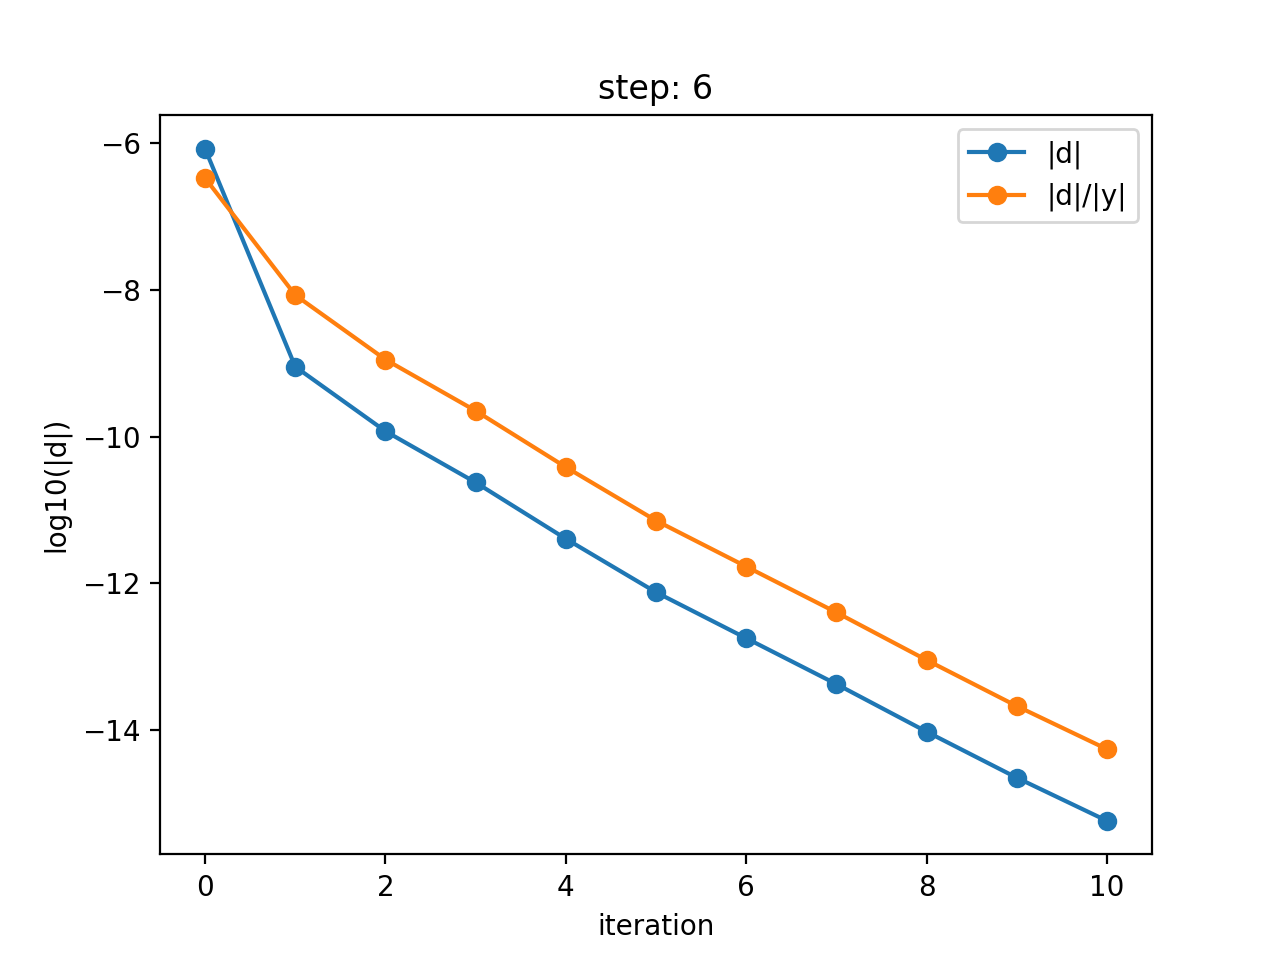

<IPython.core.display.Javascript object>


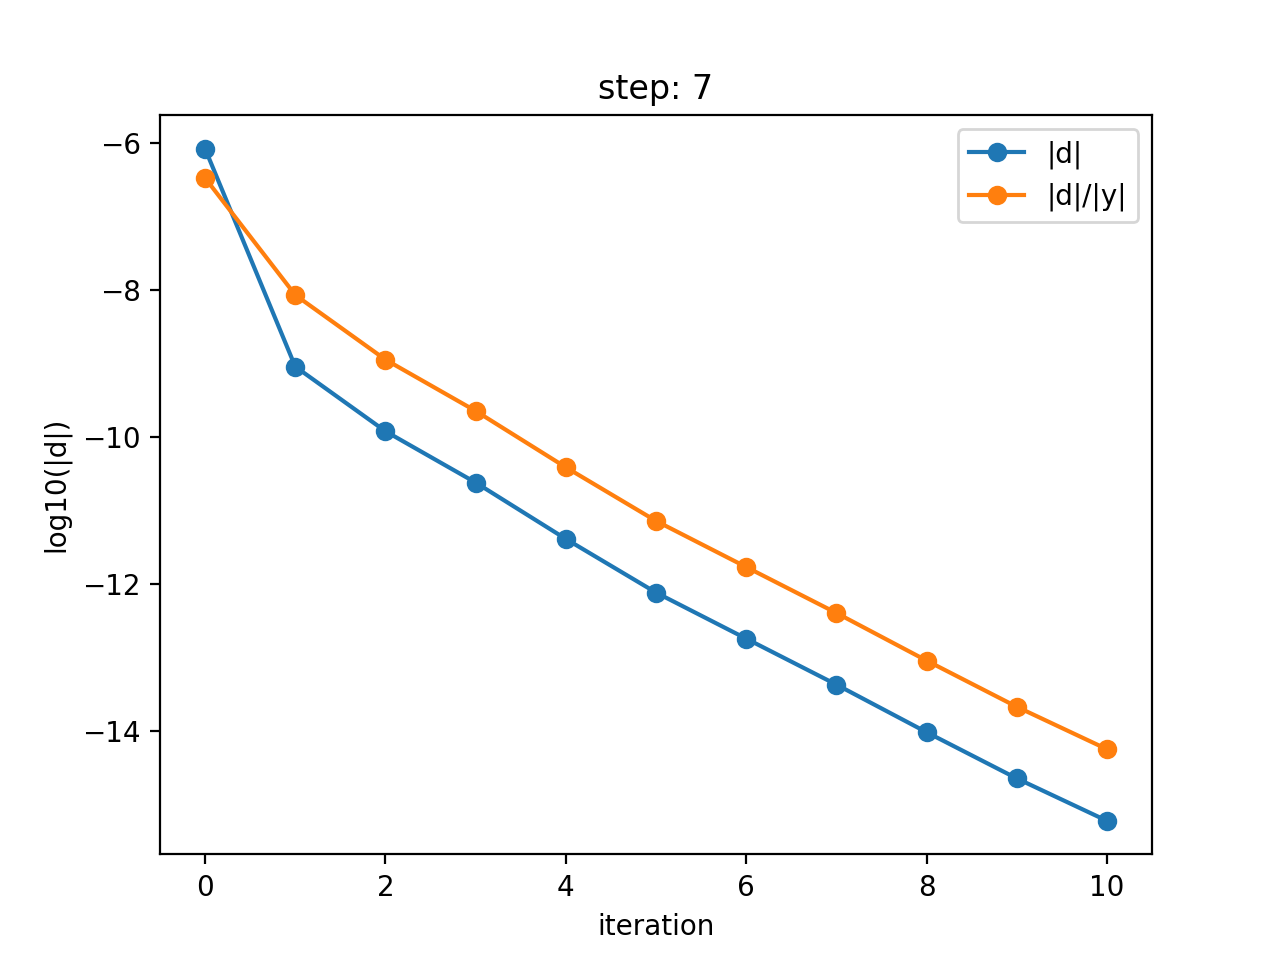

<IPython.core.display.Javascript object>


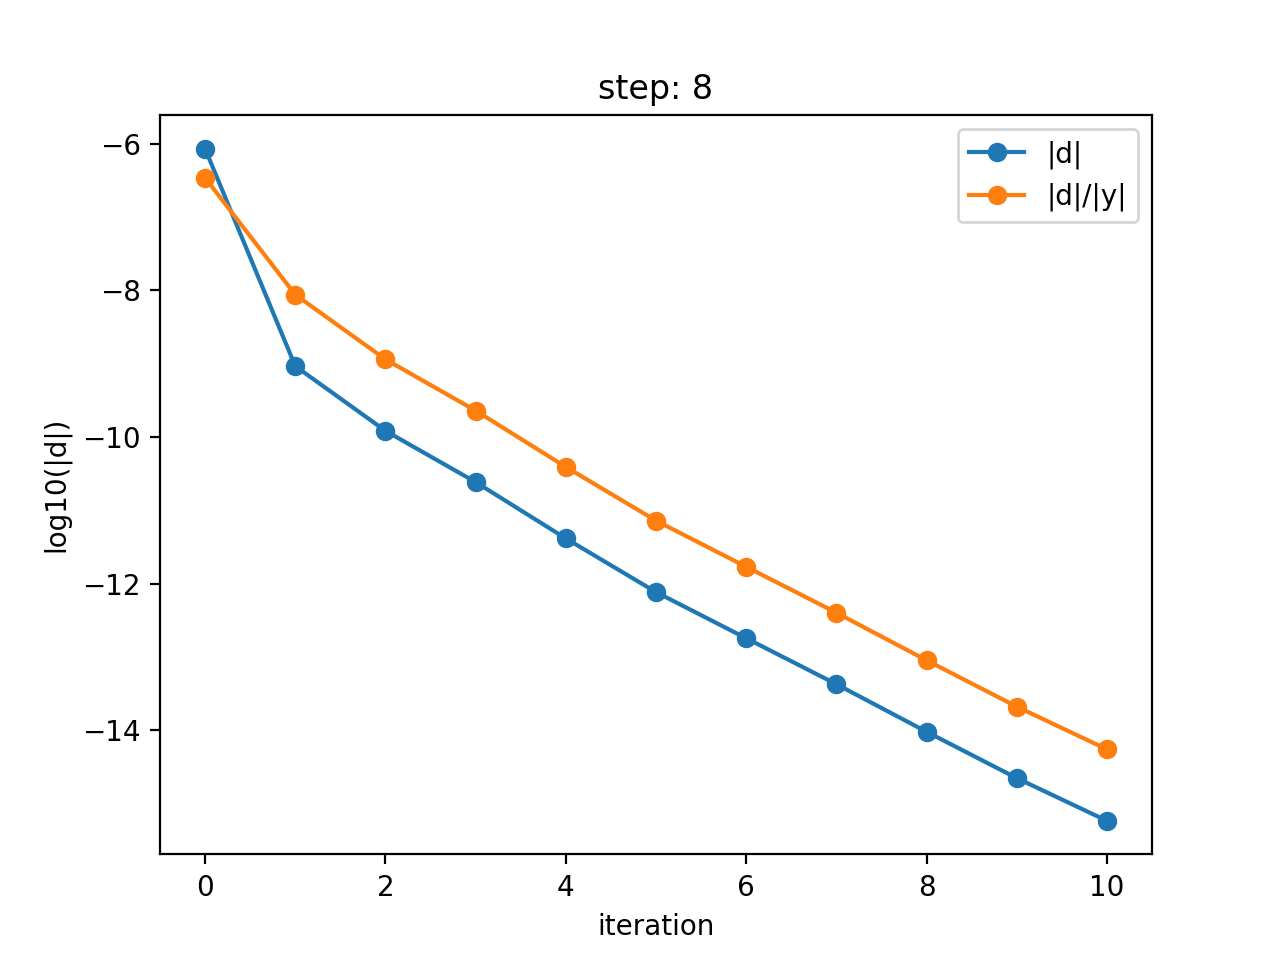

<IPython.core.display.Javascript object>


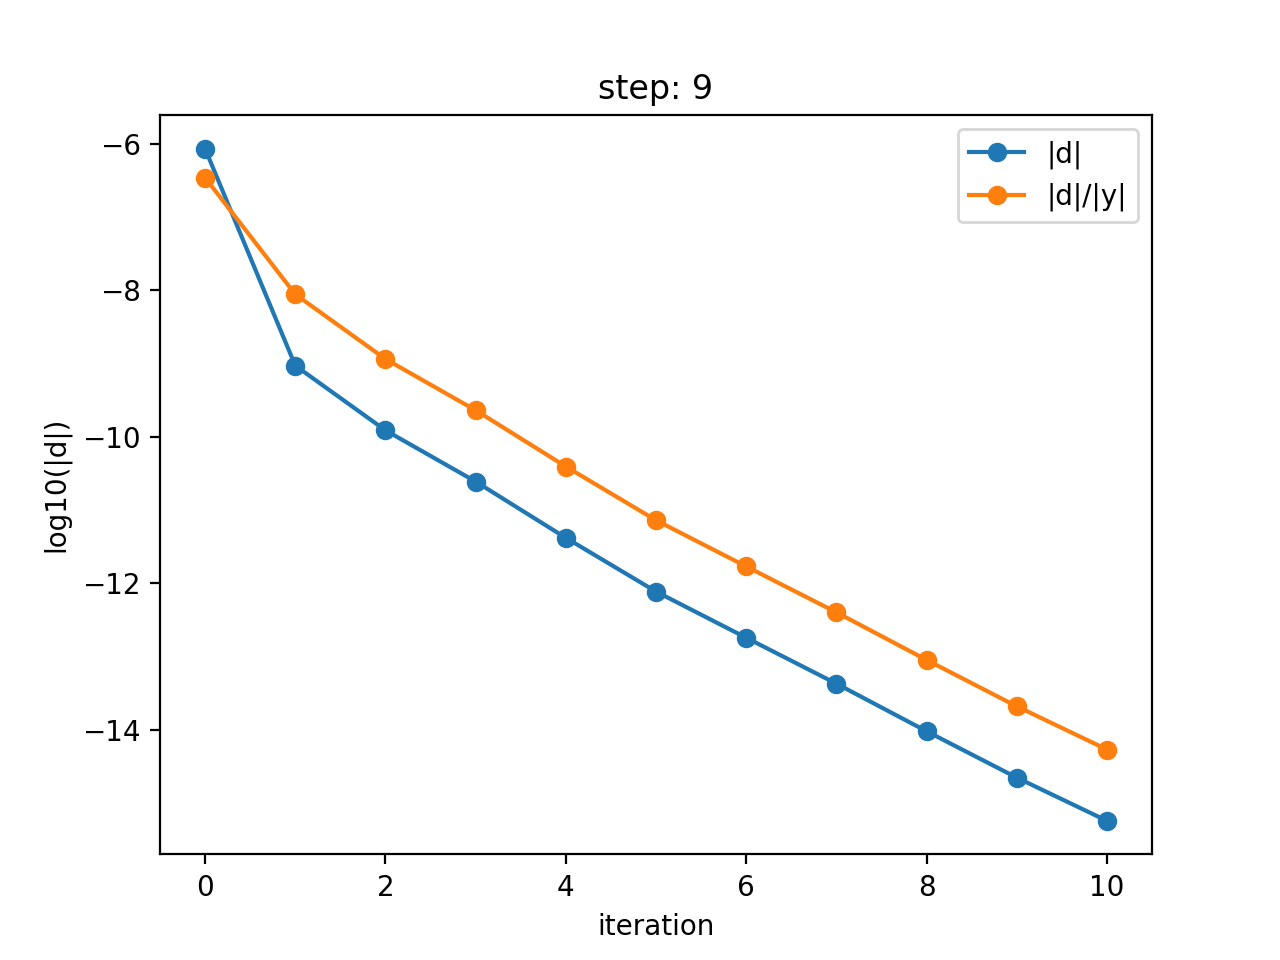

<IPython.core.display.Javascript object>


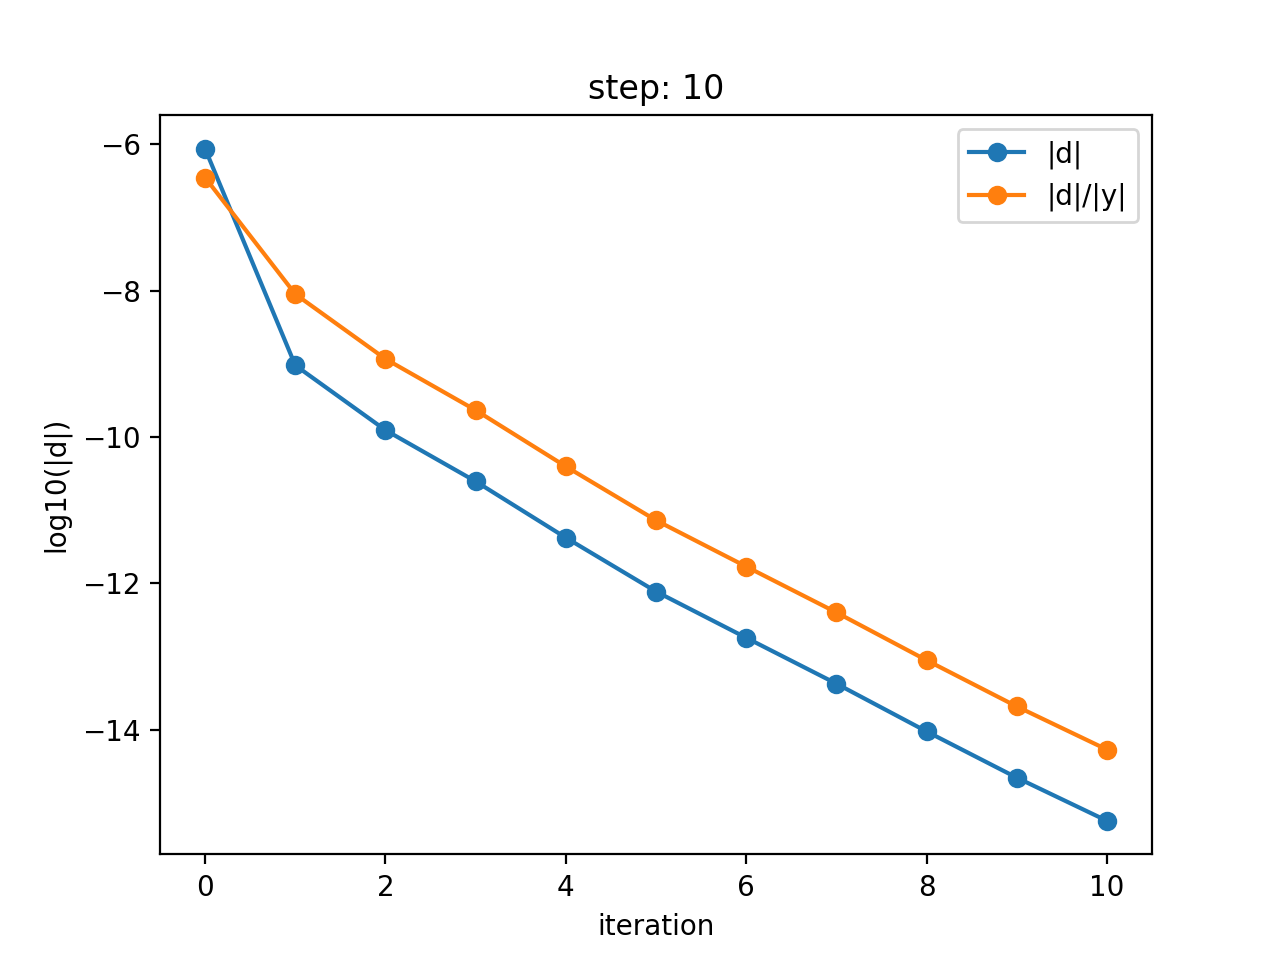

<IPython.core.display.Javascript object>


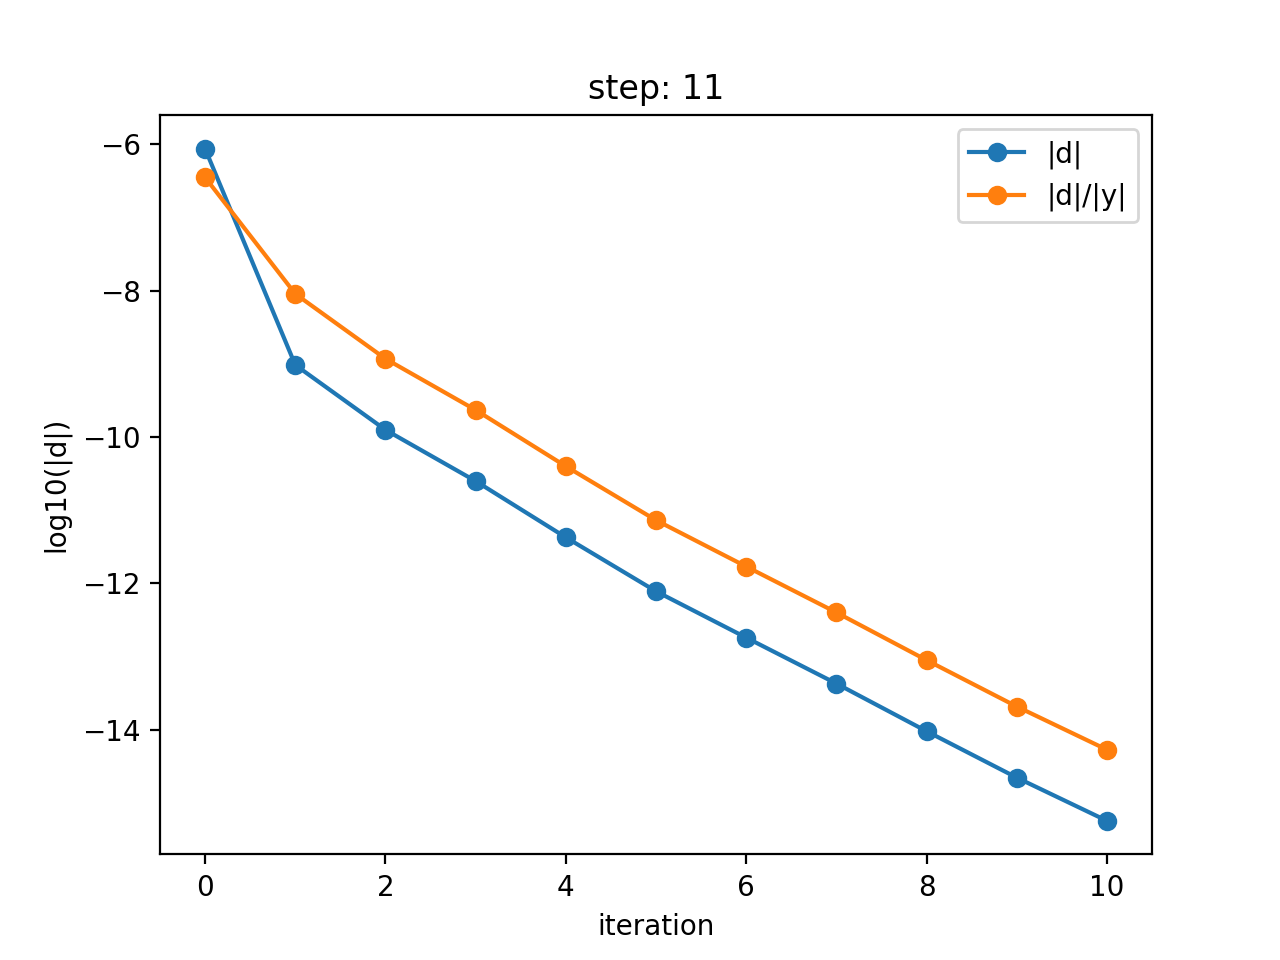

In [17]:
plotter.plot_correction_time_steps(D_uni, Y_uni)

plt.show()

Plot norm of corrections

<IPython.core.display.Javascript object>


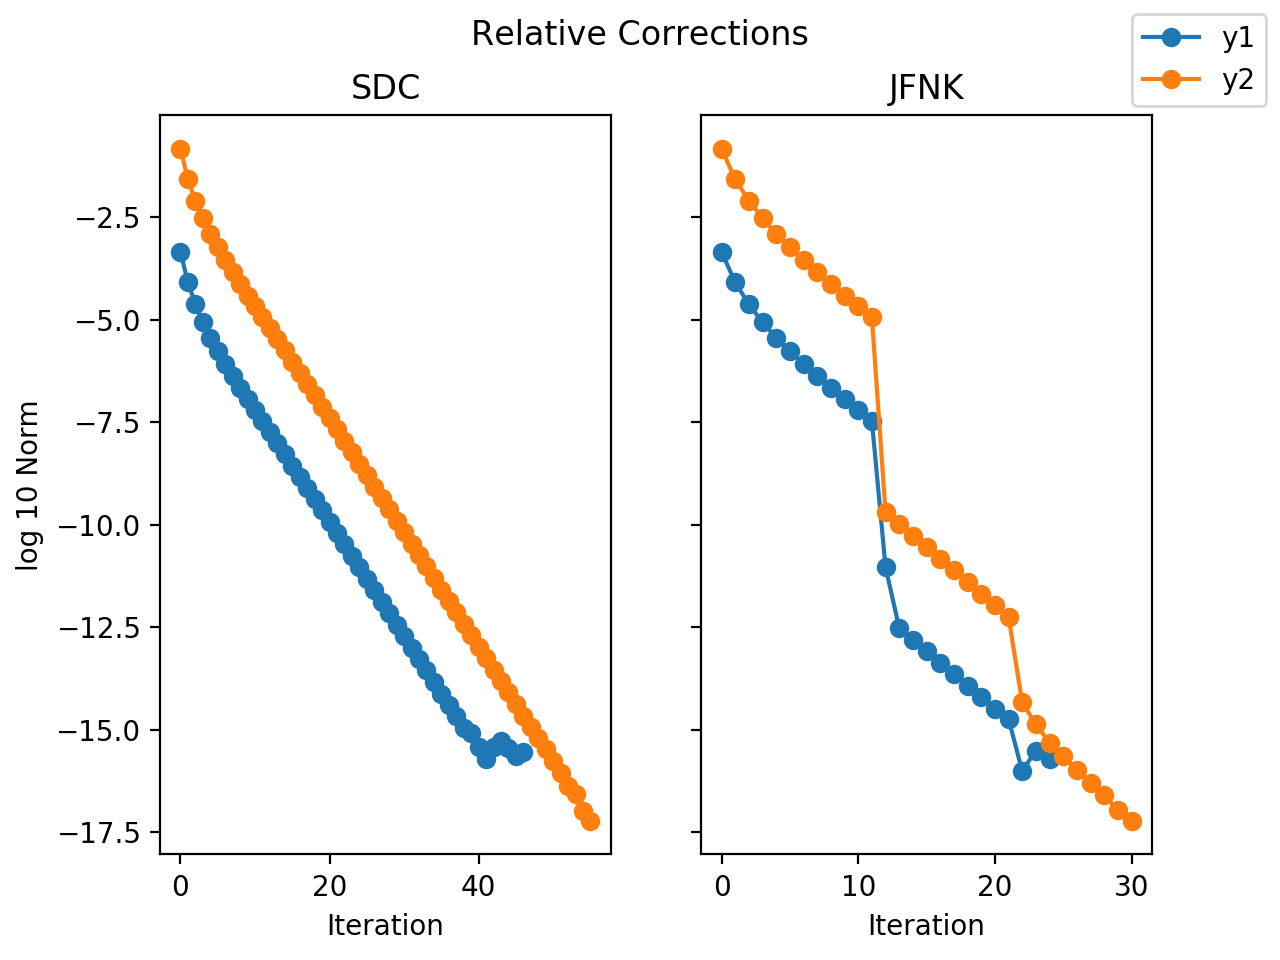

..//source/plotter.py:150: RuntimeWarning: divide by zero encountered in log10
  temp = ax.plot(np.log10(y), ls, label=label)
/Users/namdi/anaconda/lib/python3.5/site-packages/matplotlib/legend.py:652: UserWarning: Automatic legend placement (loc="best") not implemented for figure legend. Falling back on "upper right".
  warnings.warn('Automatic legend placement (loc="best") not '


In [18]:
y_spect_norm = LA.norm(y_spect, axis=0)

labels=['y1', 'y2']

plotter.corrections(d_norm_sdc, d_norm_jfnk, y_spect_norm, do_rerr=True, labels=labels, do_legend=True)
plt.show()

---
Errors

---

In [19]:
#
# error
#
aerr_be, rerr_be = analysis.error_analysis(y_be, y_spect)
aerr_sdc, rerr_sdc = analysis.error_analysis(y_sdc, y_spect)
aerr_jfnk, rerr_jfnk = analysis.error_analysis(y_jfnk, y_spect)